In [89]:
from urllib2 import urlopen, Request
from bs4 import BeautifulSoup
from lxml import etree
from pandas import DataFrame
import pandas as pd
import numpy as np
import re
import os.path 
import datetime 
import dateutil
import sys
import json
import gc


from __future__ import division

import nltk,re, pprint

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

bs = BeautifulSoup(urlopen('http://www.playbill.com/article/broadway-real-estate-com-321997'))
Theatres = DataFrame([{'name': a.getText(), 'url': a['href'], 'address': a.nextSibling[2:]} 
                      for a in bs.find_all("a") if a.has_attr('href') and '/venue/' in a['href']])

Shows = pd.read_csv('Shows.csv')

def getTags(url):
    bs = BeautifulSoup(urlopen('http://www.playbill.com' + url))
    return sorted(set([x.getText() for x in bs.find_all('h5', class_='bsp-bio-sub-text')]))

def getTagsFromBs(bs):
    return sorted(set([x.getText() for x in bs.find_all('h5', class_='bsp-bio-sub-text')]))

def seasonShows(season):
    seasonJson = json.loads(''.join(urlopen('http://www.playbill.com/ajax/loadProdSeason.jsp?year='+str(season)+'&start=0&limit=1000').readlines()))
    result = []
    for row in seasonJson['rows']:

        bs = BeautifulSoup(row)
        if (bs.find('a').has_attr('href')):
            result.append({'url':bs.find('a')['href'], 'title': bs.find('a').getText()})
    return result

def getProductionHtml(url):
    if (not url.startswith('http://www.playbill.com')):
        url = 'http://www.playbill.com' + url

    filename = 'production/' + url.split('/')[-1] + '.html' 

    if (not os.path.isfile(filename)):
        html = urlopen(url).read()
        f = open(filename, "w")
        f.write(html)
        f.close()
        print 'Wrote ' + filename
    else:
        print filename + ' already exists'

def getHtmlForYear(year):
    print 'Year: ' + str(year)
    [getProductionHtml(x) for x in list(Shows[Shows['year']==year]['url'])]
    
def getGrossHistoryForQasset(qasset):
    page = 0
    headers = []
    rows = []
    for dummy in range(0,40):
        url = 'http://www.playbill.com/production/gross?production=' + qasset + '&p=' + str(page)
        et = etree.HTML(urlopen(url).read())

        if (et.find('.//table') is None):
            break
        if page == 0:    
            headers = [child.text for th in et.find('.//table').find('thead').findall('th') for child in th.iter('a', 'span')]

        for tr in et.find('.//table').findall('.//tr'):
            fields = [span.text for td in tr.findall('td') for span in td.iter('span')]
            if (len(fields) == len(headers)):
                rows.append(dict([(i,fields[i]) for i in range(len(headers))]))        
            else:
                rows.append({0: fields[0]})

        page = page + 1

    df = DataFrame(rows)
    df.columns = headers
    return df


def getProductionGrossByUrl(url):
    filename = 'gross/'+url.split('/')[-1]+'.csv'
    
    df = DataFrame()
    
    try:
        df = pd.read_csv(filename)
    except pd.errors.EmptyDataError as e:
        pass
    except IOError as e:
        raise(e)
    except Exception as e:
        raise(e)
        
    if (df.empty):
        return df
    
    df['Week Ending'] = df['Week Ending'].apply(dateutil.parser.parse)

    for col in ['This Week Gross', 'Potential Gross', 'Diff $', 'Avg Ticket', 'Top Ticket']:
        df[col] = df[col].apply(lambda s:float(re.sub(r'\$|,','',s)))

    for col in ['Seats Sold', 'Seats in Theatre', 'Perfs', 'Previews', 'Week Number']:
        df[col] = df[col].apply(int)

    for col in ['% Cap This Week', 'Diff % cap']:
        df[col] = df[col].apply(lambda s:float(re.sub(r'%','',s)))

    return df

    
Shows['decade'] = 10 * (Shows['year'] // 10)
Shows['urlMinusVaultId'] = Shows['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))
Shows['isMusical'] = Shows.tags.str.contains('Musical')
Shows['isComedy'] = Shows.tags.str.contains('Comedy')
Shows['isDrama'] = Shows.tags.str.contains('Drama')
Shows['isPlay'] = Shows.tags.str.contains('Play')

useragent = 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'



In [110]:
BREAK

Grosses = DataFrame()

for year in range(1700,2018):
    print datetime.datetime.now()
    print year,
    for url in Shows[Shows['year']==year]['url']:
        df = getProductionGrossByUrl(url)
        df['url'] = url
        Grosses = Grosses.append(df, ignore_index=True)
        print '.', len(df),
    print
print datetime.datetime.now()

Grosses = Grosses[[u'Week Ending', u'Week Number', u'This Week Gross', u'Potential Gross',
       u'Diff $', u'Avg Ticket', u'Top Ticket', u'Seats Sold',
       u'Seats in Theatre', u'Perfs', u'Previews', u'% Cap This Week',
       u'Diff % cap', u'url']]

for col in ['Seats Sold', 'Seats in Theatre', 'Perfs', 'Previews', 'Week Number']:
    Grosses[col] = Grosses[col].apply(int)

Grosses.to_csv('grosses.csv',index=False,encoding='utf-8')

NameError: name 'BREAK' is not defined

In [117]:
Grosses[-10:]

,Week Ending,Week Number,This Week Gross,Potential Gross,Diff $,Avg Ticket,Top Ticket,Seats Sold,Seats in Theatre,Perfs,Previews,% Cap This Week,Diff % cap,url
44254,2018-03-04,41,702386.86,1016170.0,0.0,117.93,323.0,5956,1428,0,5,83.42,0.00,/production/carousel-2017-2018
44255,2018-04-01,45,1060532.00,1310600.0,125815.0,124.01,297.0,8552,1069,0,8,100.00,8.83,/production/my-fair-lady-vivian-beaumont-theat...
44256,2018-03-25,44,934717.00,1310600.0,408587.0,119.88,297.0,7797,1069,0,8,91.17,-8.83,/production/my-fair-lady-vivian-beaumont-theat...
44257,2018-03-18,43,526130.00,655300.0,0.0,123.04,297.0,4276,1069,0,4,100.00,0.00,/production/my-fair-lady-vivian-beaumont-theat...
44258,2018-04-01,45,1589033.00,1390428.0,47076.0,163.28,286.5,9732,1622,0,6,100.00,0.00,/production/harry-potter-and-the-cursed-child-...
44259,2018-03-25,44,1541957.00,1390428.0,0.0,158.44,286.5,9732,1622,0,6,100.00,0.00,/production/harry-potter-and-the-cursed-child-...
44260,2018-04-01,45,568993.00,735184.0,0.0,106.20,197.0,5358,1470,0,4,91.12,0.00,/production/summer-the-donna-summer-musical-lu...
44261,2018-04-01,45,151212.20,327612.0,0.0,61.27,0.0,2468,724,0,4,85.22,0.00,/production/travesties-american-airlines-theat...
44262,2018-04-01,45,968161.90,1020700.0,576444.9,153.09,397.0,6324,1054,0,6,100.00,0.52,/production/the-iceman-cometh-bernard-b-jacobs...
44263,2018-03-25,44,391717.00,373380.0,0.0,186.80,397.0,2097,1054,0,2,99.48,0.00,/production/the-iceman-cometh-bernard-b-jacobs...


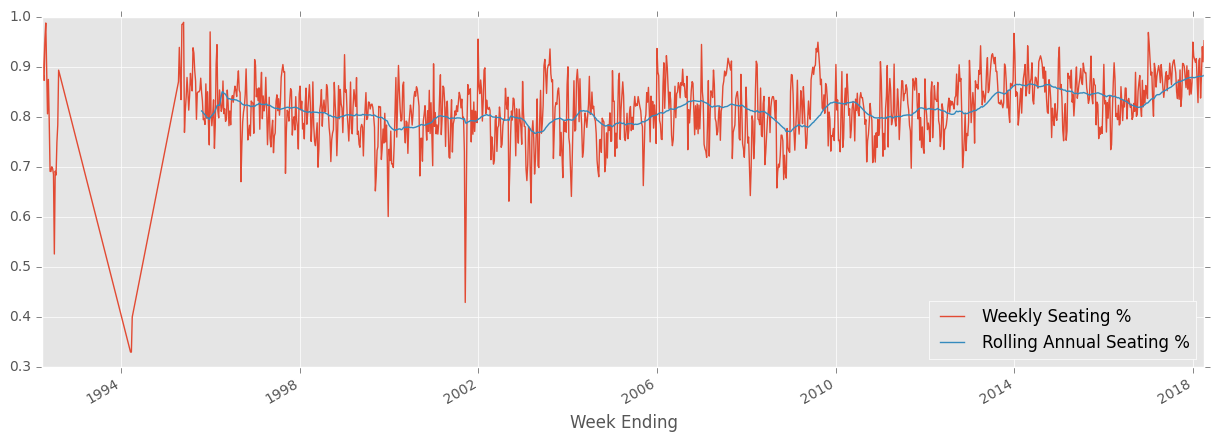

In [150]:
Grosses['Seats Sold per Perf'] = Grosses['Seats Sold'] / (Grosses['Perfs'] + Grosses['Previews'])

t = Grosses[Grosses['Top Ticket'] >0].groupby('Week Ending').sum()[['Seats Sold per Perf','Seats in Theatre']]

s = DataFrame(t['Seats Sold per Perf'] / t['Seats in Theatre']) #.plot(figsize=(20,5))

s[1]=s[0].rolling(52).mean()

s.columns = ['Weekly Seating %', 'Rolling Annual Seating %']

s.plot(figsize=(15,5))

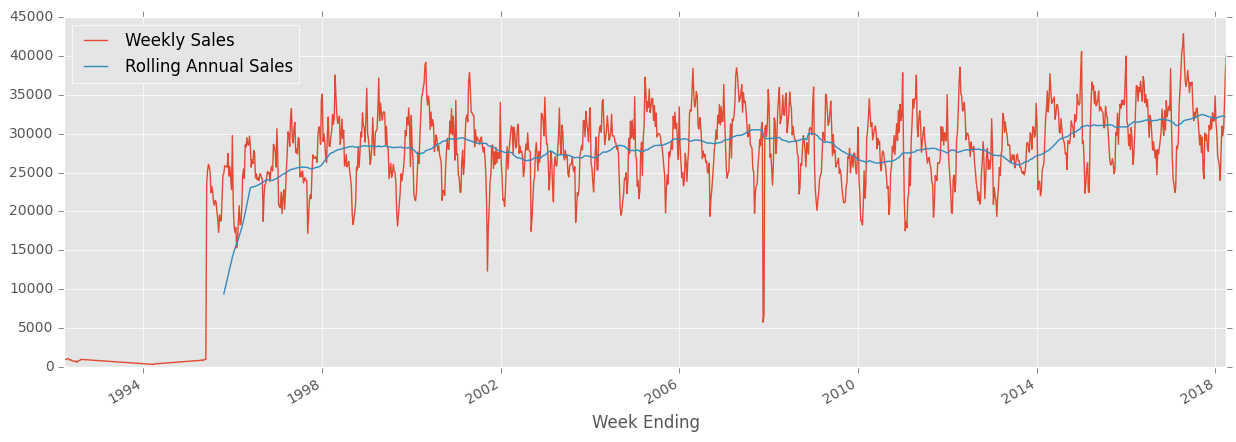

In [154]:
Grosses['Seats Sold per Perf'] = Grosses['Seats Sold'] / (Grosses['Perfs'] + Grosses['Previews'])

t = Grosses[Grosses['Top Ticket'] >0].groupby('Week Ending').sum()[['Seats Sold per Perf','Seats in Theatre']]

s = DataFrame(t['Seats Sold per Perf']) #.plot(figsize=(20,5))

s['Rolling']=s[['Seats Sold per Perf']].rolling(52).mean()

s.columns = ['Weekly Sales', 'Rolling Annual Sales']

s.plot(figsize=(15,5))

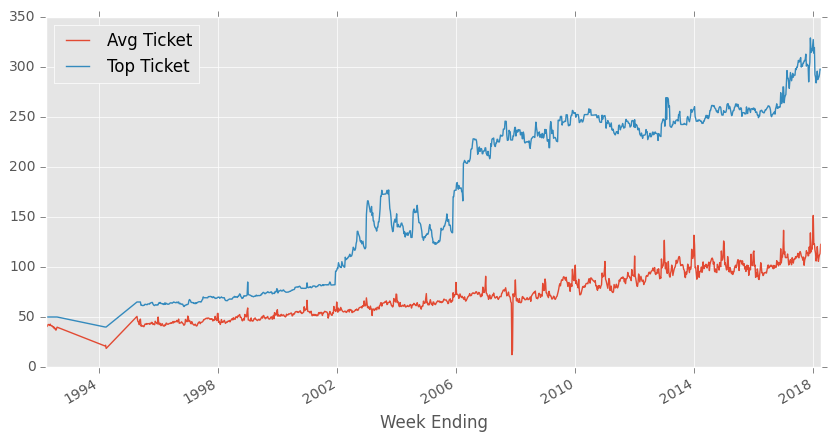

In [149]:
t = Grosses[Grosses['Top Ticket'] >0].groupby('Week Ending').mean()[['Avg Ticket' ,'Top Ticket']]


t.plot(figsize=(10,5))

In [99]:
getProductionGrossByUrl('/production/1984-hudson-theatre-2017-2018').columns

Index([u'Week Ending', u'Week Number', u'This Week Gross', u'Potential Gross',
       u'Diff $', u'Avg Ticket', u'Top Ticket', u'Seats Sold',
       u'Seats in Theatre', u'Perfs', u'Previews', u'% Cap This Week',
       u'Diff % cap'],
      dtype='object')

In [346]:
for year in range(1700,2018):
    print datetime.datetime.now()
    print year,
    for _, row in Shows[Shows['year']==year].iterrows():
        url,qasset= row[['url','qasset']]
        #url = '/production/the-recruiting-officer-new-theatre-vault-0000008900'
        filename = ('gross/' + url.split('/')[-1] + '.csv')
        if (os.path.isfile(filename)):
            print "x",
        else:
            df = getGrossHistoryForQasset(qasset)
            df.to_csv(filename,index=False,encoding='utf-8')
            print '.', len(df),
    print
print datetime.datetime.now()

2018-04-09 02:40:41.718748
1700
2018-04-09 02:40:41.721102
1701
2018-04-09 02:40:41.723194
1702
2018-04-09 02:40:41.725000
1703
2018-04-09 02:40:41.726967
1704
2018-04-09 02:40:41.728555
1705
2018-04-09 02:40:41.729951
1706
2018-04-09 02:40:41.731403
1707
2018-04-09 02:40:41.732600
1708
2018-04-09 02:40:41.734184
1709
2018-04-09 02:40:41.735392
1710
2018-04-09 02:40:41.736535
1711
2018-04-09 02:40:41.737736
1712
2018-04-09 02:40:41.739061
1713
2018-04-09 02:40:41.740800
1714
2018-04-09 02:40:41.742051
1715
2018-04-09 02:40:41.743366
1716
2018-04-09 02:40:41.744848
1717
2018-04-09 02:40:41.746435
1718
2018-04-09 02:40:41.747758
1719
2018-04-09 02:40:41.748918
1720
2018-04-09 02:40:41.752430
1721
2018-04-09 02:40:41.754165
1722
2018-04-09 02:40:41.755820
1723
2018-04-09 02:40:41.757461
1724
2018-04-09 02:40:41.759087
1725
2018-04-09 02:40:41.760242
1726
2018-04-09 02:40:41.762036
1727
2018-04-09 02:40:41.763604
1728
2018-04-09 02:40:41.764998
1729
2018-04-09 02:40:41.766408
1730
2018-04-

In [12]:
BLOCK

qassetsForUrl = {}

for year in range(1700,2018):
    print datetime.datetime.now()
    print year,
    for url in list(Shows[Shows['year'] == year]['url']):
        #url = '/production/the-recruiting-officer-new-theatre-vault-0000008900'
        filename = (url + '.html')[1:]
        if (os.path.isfile(filename)):
            f = open(filename)
            bs = BeautifulSoup(f.read())
            f.close()
            qasset = ''
            hrefs = [a['href'] for a in bs.find_all('a') if a.has_attr('href') and 'qasset=' in a['href']]
            if (len(hrefs) > 0 and len(hrefs[0]) > 0):
                qasset = hrefs[0].split('&qasset=')[-1].split('&')[0]
            qassetsForUrl[url] = qasset
            bs.decompose()
            gc.collect() #BeautifulSoup memory leak!!!! :(((
            print ".",
        else:
            print filename + ' not found'
    print
print datetime.datetime.now()

qassetsForUrl

2018-04-06 17:55:02.040937
1700
2018-04-06 17:55:02.044300
1701
2018-04-06 17:55:02.046284
1702
2018-04-06 17:55:02.047449
1703
2018-04-06 17:55:02.048711
1704
2018-04-06 17:55:02.050808
1705
2018-04-06 17:55:02.052202
1706
2018-04-06 17:55:02.053635
1707
2018-04-06 17:55:02.054799
1708
2018-04-06 17:55:02.056062
1709
2018-04-06 17:55:02.057298
1710
2018-04-06 17:55:02.058689
1711
2018-04-06 17:55:02.060069
1712
2018-04-06 17:55:02.061501
1713
2018-04-06 17:55:02.063413
1714
2018-04-06 17:55:02.064782
1715
2018-04-06 17:55:02.066180
1716
2018-04-06 17:55:02.067547
1717
2018-04-06 17:55:02.068955
1718
2018-04-06 17:55:02.070178
1719
2018-04-06 17:55:02.071341
1720
2018-04-06 17:55:02.072542
1721
2018-04-06 17:55:02.073758
1722
2018-04-06 17:55:02.074917
1723
2018-04-06 17:55:02.076594
1724
2018-04-06 17:55:02.077926
1725
2018-04-06 17:55:02.079206
1726
2018-04-06 17:55:02.080508
1727
2018-04-06 17:55:02.081857
1728
2018-04-06 17:55:02.083428
1729
2018-04-06 17:55:02.084674
1730
2018-04-

{'/production/artists-and-models-1927-winter-garden-theatre-vault-0000011620': '00000150-aea6-d936-a7fd-eef6ed370000',
 '/production/intimate-relations-ambassador-theatre-vault-0000001087': '00000150-aea2-d936-a7fd-eef607c30003',
 '/production/the-good-body-booth-theatre-vault-0000001662': '00000150-aea2-d936-a7fd-eef6739e0004',
 '/production/naughty-naught-00-knickerbocker-theatre-vault-0000000522': '00000150-aea1-d936-a7fd-eef5c7ae0001',
 '/production/faust-center-theatre-vault-0000013201': '00000150-aea8-d936-a7fd-eefc2a590001',
 '/production/red-hands-woods-museum-and-metropolitan-vault-0000012838': '00000150-aea7-d936-a7fd-eef7dad60000',
 '/production/wang-broadway-theatre-vault-0000002270': '00000150-ae98-d936-a7fd-eefc62380007',
 '/production/the-33rd-annual-tony-awards-1979-shubert-theatre-vault-0000013914': '00000150-aea8-d936-a7fd-eefc73340000',
 '/production/newsies-nederlander-theatre-vault-0000013858': '00000150-aea8-d936-a7fd-eefc72fd0000',
 '/production/the-wilderness-em

In [ ]:
urlWeeksMap = {}

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

for url in Shows['url']:
        url
        #url = '/production/the-recruiting-officer-new-theatre-vault-0000008900'
        filename = ('gross/' + url.split('/')[-1] + '.csv')
        if file_len(filename) > 1:
            df = pd.read_csv(filename)
            urlWeeksMap[url] = len(df)

urlWeeksMap

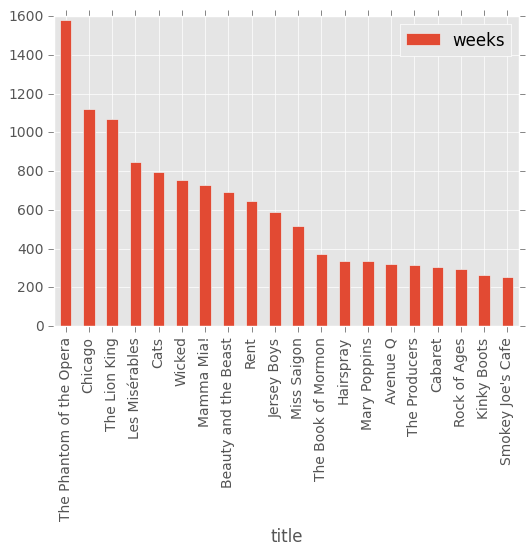

In [24]:
#Shows['weeks'] = Shows.url.apply(lambda url: urlWeeksMap.get(url)).fillna(0).apply(int)
#Shows.to_csv('Shows.csv',index=False,encoding='utf-8')
Shows.sort_values('weeks', ascending=False)[:20][['title','weeks']].set_index('title').plot.bar()

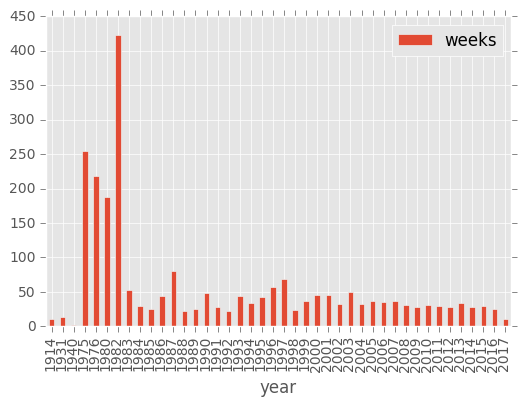

In [46]:
Shows[Shows.weeks>0].groupby('year').mean()[['weeks']].plot.bar()

In [49]:
Shows[(Shows.weeks>0)&(Shows.year==1985)]

,title,url,year,tags,decade,urlMinusVaultId,isMusical,isComedy,isDrama,isPlay,tags_simplified,description,qasset,weeks
11595,The Odd Couple,/production/the-odd-couple-broadhurst-theatre-...,1985,Broadway/Comedy,1980,/production/the-odd-couple-broadhurst-theatre,False,True,False,False,Other,Two suddenly single pals — a sloppy sportswrit...,00000150-ae93-d936-a7fd-eef7499b0001,38
11596,Singin' in the Rain,/production/singin-in-the-rain-george-gershwin...,1985,Broadway/Musical/Original,1980,/production/singin-in-the-rain-george-gershwin...,True,False,False,False,Broadway/Musical/Original,A 1920s silent-screen romantic duo prepares fo...,00000150-aea8-d936-a7fd-eefc3a1e0000,50
11597,Song and Dance,/production/song-and-dance-royale-theatre-vaul...,1985,Broadway/Musical/Original,1980,/production/song-and-dance-royale-theatre,True,False,False,False,Broadway/Musical/Original,In the first act of this Andrew Lloyd Webber-D...,00000150-aea6-d936-a7fd-eef62efc0003,62
11598,The Search for Signs of Intelligent Life in th...,/production/the-search-for-signs-of-intelligen...,1985,Broadway/Original/Solo,1980,/production/the-search-for-signs-of-intelligen...,False,False,False,False,Other,Lily Tomlin plays multiple roles in Jane Wagne...,00000150-aea5-d936-a7fd-eef5cb060000,55
11599,The Iceman Cometh,/production/the-iceman-cometh-lunt-fontanne-th...,1985,Broadway/Drama,1980,/production/the-iceman-cometh-lunt-fontanne-th...,False,False,True,False,Other,Set in the summer of 1912 at Harry Hope's salo...,00000150-aea3-d936-a7fd-eef7cc600003,11
11600,Tango Argentino,/production/tango-argentino-mark-hellinger-the...,1985,Broadway/Original/Revue,1980,/production/tango-argentino-mark-hellinger-the...,False,False,False,False,Other,A century of the tango is celebrated in an eve...,00000150-aea3-d936-a7fd-eef7ea2d0003,25
11601,The Marriage of Figaro,/production/the-marriage-of-figaro-circle-in-t...,1985,Broadway/Comedy/Original,1980,/production/the-marriage-of-figaro-circle-in-t...,False,True,False,False,Broadway/Comedy/Original,A Count's valet prepares to marry the Countess...,00000150-aea2-d936-a7fd-eef6ec4e0004,13
11604,I'm Not Rappaport,/production/im-not-rappaport-booth-theatre-vau...,1985,Broadway/Musical/Original,1980,/production/im-not-rappaport-booth-theatre,True,False,False,False,Broadway/Musical/Original,"A lifelong radical and world-class kibitzer, r...",00000150-aea8-d936-a7fd-eefc3a1e0001,113
11605,The Boys of Winter,/production/the-boys-of-winter-biltmore-theatr...,1985,Broadway/Original/Play,1980,/production/the-boys-of-winter-biltmore-theatre,False,False,False,True,Broadway/Original/Play,Seven marines preparing for a mission in Vietn...,00000150-aea2-d936-a7fd-eef629ce0003,5
11606,The Mystery of Edwin Drood,/production/the-mystery-of-edwin-drood-imperia...,1985,Broadway/Musical/Original,1980,/production/the-mystery-of-edwin-drood-imperia...,True,False,False,False,Broadway/Musical/Original,In the musical adaptation of Charles Dickens's...,00000150-aea4-d936-a7fd-eef442aa0003,79


In [40]:

url = '/production/the-phantom-of-the-opera-majestic-theatre-vault-0000007818'
'gross/'+url.split('/')[-1]+'.csv'

'gross/the-phantom-of-the-opera-majestic-theatre-vault-0000007818.csv'

In [16]:
#Shows['qasset'] = Shows.url.apply(lambda url: qassetsForUrl[url])
Shows.to_csv('Shows.csv',index=False,encoding='utf-8')
Shows

,title,url,year,tags,decade,urlMinusVaultId,isMusical,isComedy,isDrama,isPlay,tags_simplified,description,qasset
0,The Recruiting Officer,/production/the-recruiting-officer-new-theatre...,1732,Broadway/Original/Play,1730,/production/the-recruiting-officer-new-theatre,False,False,False,True,Broadway/Original/Play,NaN,00000150-aea5-d936-a7fd-eef572310004
1,The Mock Doctor,/production/the-mock-doctor-nassau-street-thea...,1749,Broadway/Original/Play,1740,/production/the-mock-doctor-nassau-street-theatre,False,False,False,True,Broadway/Original/Play,NaN,00000150-aea5-d936-a7fd-eef572310002
2,The Devil to Pay,/production/the-devil-to-pay-nassau-street-the...,1749,Broadway/Drama/Original,1740,/production/the-devil-to-pay-nassau-street-the...,False,False,True,False,Broadway/Drama/Original,NaN,00000150-aea5-d936-a7fd-eef5a9600004
3,Damon and Phillida,/production/damon-and-phillida-nassau-street-t...,1749,Broadway/Musical/Opera/Original,1740,/production/damon-and-phillida-nassau-street-t...,True,False,False,False,Other,NaN,00000150-aea5-d936-a7fd-eef572310003
4,Richard III,/production/king-richard-iii-nassau-street-the...,1749,Broadway/Original/Play,1740,/production/king-richard-iii-nassau-street-the...,False,False,False,True,Broadway/Original/Play,"Richard, Duke of York, plots murders, marriage...",00000150-aea5-d936-a7fd-eef5a9600003
5,Spanish Friar,/production/spanish-friar-nassau-street-theatr...,1749,Broadway/Original/Play,1740,/production/spanish-friar-nassau-street-theatre,False,False,False,True,Broadway/Original/Play,NaN,00000150-aea5-d936-a7fd-eef572310001
6,The Orphan,/production/the-orphan-nassau-street-theatre-v...,1749,Broadway/Original/Play,1740,/production/the-orphan-nassau-street-theatre,False,False,False,True,Broadway/Original/Play,NaN,00000150-aea5-d936-a7fd-eef572310000
7,The Stage Coach,/production/the-stage-coach-nassau-street-thea...,1750,Broadway/Original/Play,1750,/production/the-stage-coach-nassau-street-theatre,False,False,False,True,Broadway/Original/Play,NaN,00000150-aea5-d936-a7fd-eef572300004
8,Love for Love,/production/love-for-love-nassau-street-theatr...,1750,Broadway/Comedy/Original/Play,1750,/production/love-for-love-nassau-street-theatre,False,True,False,True,Broadway/Comedy/Original/Play,"The playboy Valentine prepares, at least nomin...",00000150-aea5-d936-a7fd-eef572300003
9,The Recruiting Officer,/production/the-recruiting-officer-nassau-stre...,1750,Broadway/Play,1750,/production/the-recruiting-officer-nassau-stre...,False,False,False,True,Other,NaN,00000150-aea5-d936-a7fd-eef5a9600002


In [ ]:
BLOCK
tagsForUrl = {}

for year in range(1700,2018):
    print datetime.datetime.now()
    print year,
    for url in list(Shows[Shows['year'] == year]['url']):
        filename = (url + '.html')[1:]
        if (os.path.isfile(filename)):
            f = open(filename)
            bs = BeautifulSoup(f.read())
            f.close()
            tagsForUrl[url] = '/'.join(getTagsFromBs(bs))
            bs.decompose()
            gc.collect() #BeautifulSoup memory leak!!!! :(((
            print ".",
        else:
            print filename + ' not found'
    print
print datetime.datetime.now()

Shows.to_csv('Shows.csv',index=False,encoding='utf-8')

In [ ]:
BLOCK

descriptionsForUrl = {}

for year in range(1700,2018):
    print datetime.datetime.now()
    print year,
    for url in list(Shows[Shows['year'] == year]['url']):
        filename = (url + '.html')[1:]
        if (os.path.isfile(filename)):
            f = open(filename)
            bs = BeautifulSoup(f.read())
            f.close()
            descriptionsForUrl[url] = [meta['content'] for meta in bs.find_all('meta') if meta.has_attr('name') and meta['name'] == 'description'][0]
            bs.decompose()
            gc.collect() #BeautifulSoup memory leak!!!! :(((
            print ".",
        else:
            print filename + ' not found'
    print
print datetime.datetime.now()

descriptionsForUrl

In [2]:
print len(Shows[Shows.description.isnull()])
print len(Shows[~(Shows.description.isnull())])

8457
4429


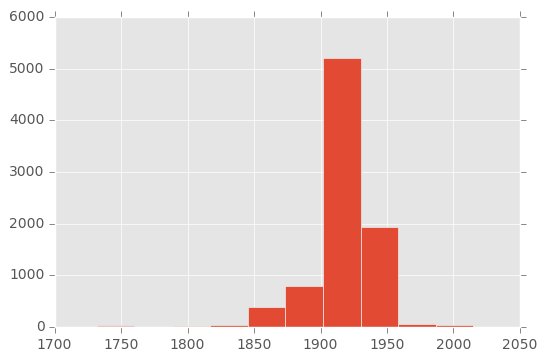

In [12]:
Shows[Shows.description.isnull()].year.hist()

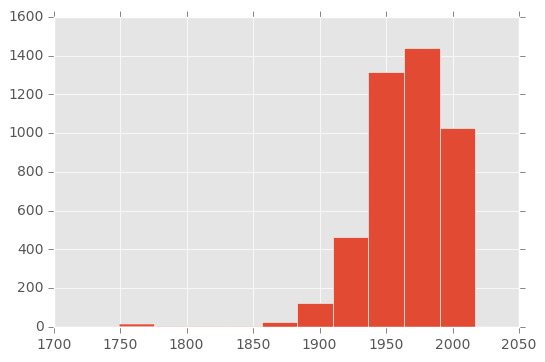

In [13]:
Shows[~Shows.description.isnull()].year.hist()

In [19]:
print len(Shows[~(Shows.isComedy|Shows.isDrama|Shows.isPlay|Shows.isMusical)])
print len(Shows[(Shows.isComedy|Shows.isDrama|Shows.isPlay|Shows.isMusical)])

2525
10361


In [32]:
len(Shows[Shows.tags.str.contains('Tragedy')])

159

In [31]:
print len (Shows[Shows.isComedy&Shows.isDrama])
print len (Shows[Shows.isMusical&Shows.isPlay])
print len (Shows[Shows.isComedy&Shows.isMusical])
print len (Shows[Shows.isComedy&Shows.isPlay])
print len (Shows[Shows.isDrama&Shows.isMusical])
print len (Shows[Shows.isDrama&Shows.isPlay])

70
63
374
864
75
626


In [41]:
def boolToInt(b):
    return 1 if b else 0

nltk.FreqDist((Shows.isComedy.apply(boolToInt) + Shows.isDrama.apply(boolToInt) + Shows.isPlay.apply(boolToInt) + Shows.isMusical.apply(boolToInt)))

Counter({0: 2525, 1: 8520, 2: 1751, 3: 73, 4: 17})

In [ ]:
print len(Shows[Shows.tags.str.contains('Original')])
print len(Shows)

In [ ]:
Shows['urlMinusVaultId'] = Shows['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))

Originals = Shows[Shows.tags.str.contains('Original')]
Originals.groupby('year').nunique()[['urlMinusVaultId']].plot.bar(figsize=(30,5))

In [ ]:
Shows['decade'] = 10 * (Shows['year'] // 10)

In [15]:
nltk.FreqDist(list(Shows.tags)).most_common()

[('Broadway/Original/Play', 2683),
 ('Broadway/Musical/Original', 1676),
 ('Broadway/Comedy/Original', 1170),
 ('Broadway/Drama/Original', 984),
 ('Broadway/Original', 670),
 ('Broadway/Comedy/Original/Play', 570),
 ('Broadway', 465),
 ('Broadway/Drama/Original/Play', 409),
 ('Broadway/Play', 396),
 ('Broadway/Original/Revue', 342),
 ('Broadway/Comedy', 336),
 ('Broadway/Musical', 335),
 ('Broadway/Drama', 229),
 ('Broadway/Comedy/Musical/Original', 194),
 ('Broadway/Original/Special', 141),
 ('Broadway/Drama/Play', 136),
 ('Broadway/Comedy/Play', 131),
 ('Broadway/Opera/Original', 110),
 ('Broadway/Musical/Original/Revue', 106),
 ('Broadway/Farce/Original', 101),
 ('Broadway/Operetta/Original', 83),
 ('Broadway/Concert/Original', 64),
 ('Broadway/Farce/Original/Play', 59),
 ('Broadway/One Act/Original', 55),
 ('Broadway/One Act/Original/Play', 54),
 ('Broadway/Comedy/Musical/Operetta', 51),
 ('Broadway/Tragedy', 50),
 ('Broadway/Original/Solo', 47),
 ('Broadway/Dance/Original', 44),
 

In [45]:
nltk.FreqDist([y for x in list(Shows.tags.str.split('/')) for y in x]).most_common()

[('Broadway', 12764),
 ('Original', 10321),
 ('Play', 4775),
 ('Musical', 2782),
 ('Comedy', 2779),
 ('Drama', 1924),
 ('Revue', 505),
 ('Opera', 295),
 ('Special', 269),
 ('Farce', 247),
 ('Operetta', 235),
 ('One Act', 201),
 ('Tragedy', 159),
 ('Solo', 122),
 ('Off-Broadway', 122),
 ('Concert', 110),
 ('Play with Music', 102),
 ('Dance', 97),
 ('Vaudeville', 44),
 ('Benefit', 38),
 ('Burlesque', 37),
 ('Thriller', 21),
 ('Magic', 6),
 ('Holiday', 4),
 ('Story', 1),
 ('Theatrical Experience', 1)]

In [18]:
keep_tags = [x for (x,_) in nltk.FreqDist(list(Shows.tags)).most_common()][:8]

Shows['tags_simplified'] = Shows.tags.apply(lambda tag: tag if tag in  keep_tags else 'Other')

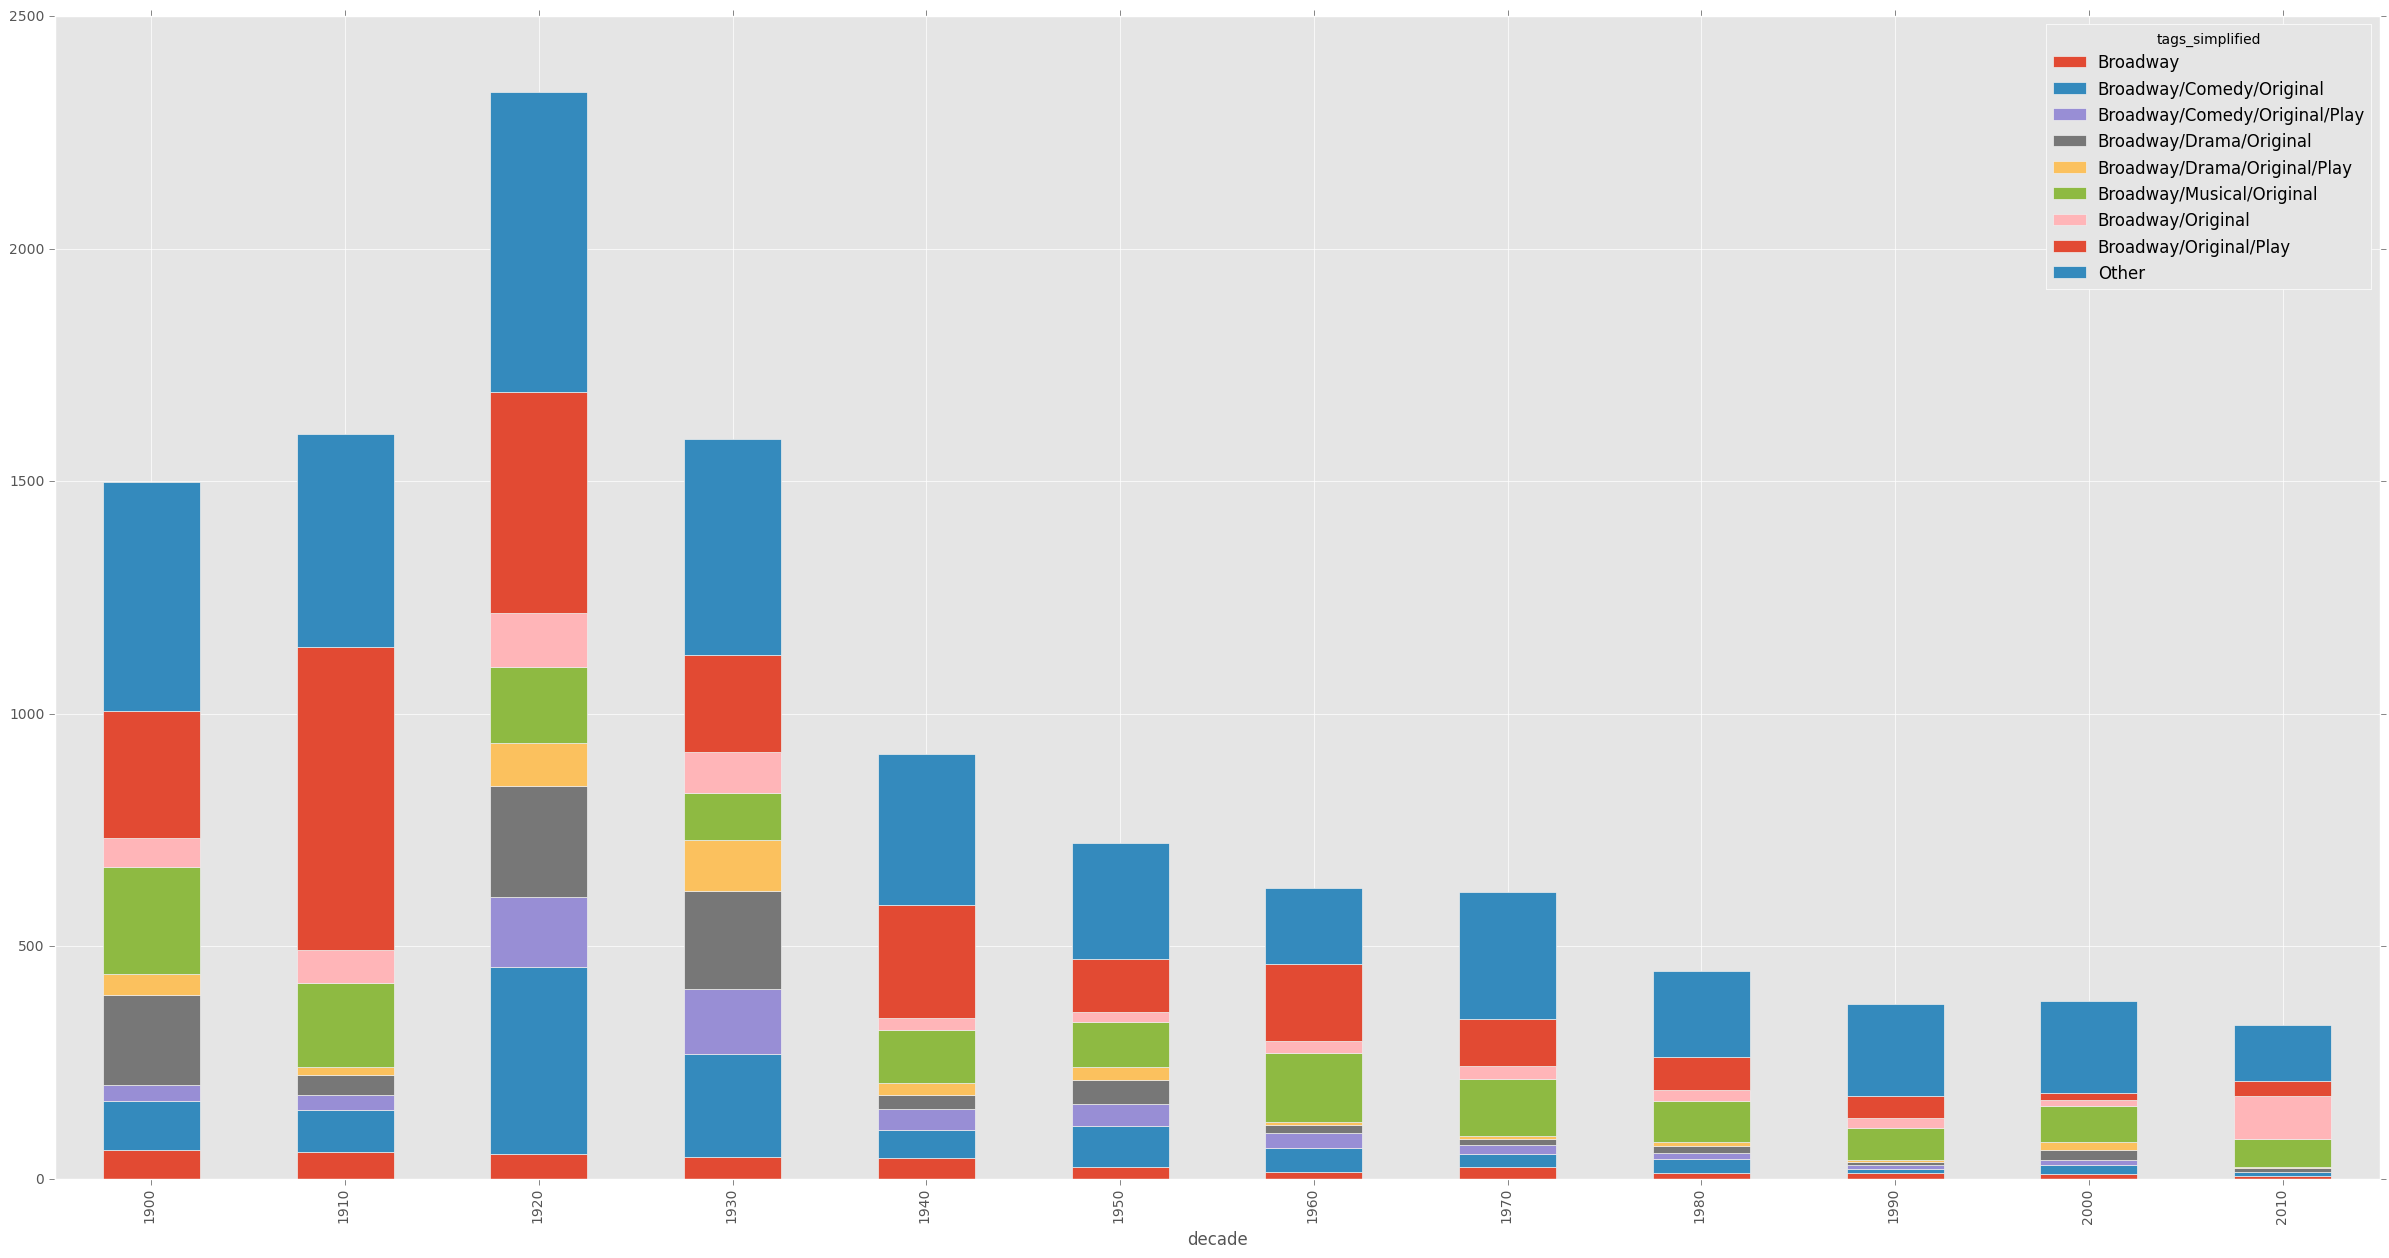

In [19]:
Shows[(Shows.year>1900)].groupby(['decade','tags_simplified']).nunique()['urlMinusVaultId'].unstack().plot.bar(stacked=True,figsize=(30,15))


In [ ]:
t = Shows[(Shows.year>1900)] \
    .groupby(['decade','isComedy']).nunique()['urlMinusVaultId'].unstack() #.plot.bar(stacked=True,figsize=(30,15))
t['Total'] = t.sum(axis=1)

DataFrame(t[True] / t['Total']).plot.bar(figsize=(30,15))

In [ ]:
Shows[(Shows.year>1900)].groupby(['decade','isMusical']).nunique()['urlMinusVaultId'].unstack().plot.bar(stacked=True,figsize=(30,15))

In [ ]:
Shows[~Shows.isMusical]

In [ ]:
t = Shows[(Shows.year>1900) & (Shows.tags.isin(['Broadway/Original/Play','Broadway/Musical/Original','Broadway/Comedy/Original','Broadway/Drama/Original']))] \
    .groupby(['decade','tags']).nunique()['urlMinusVaultId'].unstack() #.plot.bar(stacked=True,figsize=(30,15))
    
t['Total'] = t.sum(axis=1)

for tag in ['Broadway/Original/Play','Broadway/Musical/Original','Broadway/Comedy/Original','Broadway/Drama/Original']:
    t[tag] = t[tag] / t['Total']
    
t[['Broadway/Musical/Original']].plot(figsize=(30,15))

In [ ]:
DataFrame(nltk.FreqDist(list(Shows[Shows.year.between(1920,1930)].tags)).most_common()).set_index(0)[1].plot.pie()

In [ ]:
Shows[Shows.tags.str.contains('Theatrical Experience')]['url'][12824]

In [ ]:
Shows[Shows.tags.str.contains('Musical')].groupby('year').nunique()[['urlMinusVaultId']].plot.bar(figsize=(30,5))

In [ ]:
Shows[Shows.tags.str.contains('Thriller')]

In [48]:
Shows['description'] = Shows.url.apply(lambda url: descriptionsForUrl[url])
Shows.to_csv('Shows.csv',index=False,encoding='utf-8')

In [49]:
Shows[Shows.description.str.len() == 907]

,title,url,year,tags,decade,urlMinusVaultId,isMusical,isComedy,isDrama,isPlay,tags_simplified,description
12876,Mean Girls,/production/mean-girls-august-wilson-theatre-2...,2017,Broadway/Musical/Original,2010,/production/mean-girls-august-wilson-theatre,True,False,False,False,Broadway/Musical/Original,Mean Girls is now a ferociously funny new musi...


In [77]:
descriptions = '\n'.join(list(set(Shows[(Shows.description.str.len() > 0)&(Shows.isComedy)].description)))
comedyCol = nltk.Text(nltk.word_tokenize(descriptions)).collocations()
descriptions = '\n'.join(list(set(Shows[(Shows.description.str.len() > 0)&(Shows.isDrama)].description)))
dramaCol = nltk.Text(nltk.word_tokenize(descriptions)).collocations()
descriptions = '\n'.join(list(set(Shows[(Shows.description.str.len() > 0)&(Shows.isMusical)].description)))
musicalCol = nltk.Text(nltk.word_tokenize(descriptions)).collocations()
descriptions = '\n'.join(list(set(Shows[(Shows.description.str.len() > 0)&(Shows.isPlay)].description)))
playCol = nltk.Text(nltk.word_tokenize(descriptions)).collocations()

New York; Neil Simon; Bernard Shaw; World War; George Bernard; Fumed
Oak; married couple; William Shakespeare; musical adaptation; Jackie
Mason; one-act plays; Noel Coward; Pulitzer Prize-winning; Hands
Across; Red Peppers; San Francisco; Shadow Play; dark comedy; Still
Life; Greenwich Village
Pulitzer Prize-winning; World War; Lillian Hellman; Tennessee
Williams; Prize-winning play; Eugene O'Neill; Henrik Ibsen; New York;
would rather; August Strindberg; Edward Albee; Giacomo Puccini; Oscar
Wilde; Pulitzer Prize; Anton Chekhov; mental illness; must deal;
unrequited love; New Orleans; Tony Award-winning
musical adaptation; New York; World War; York City; Best Musical; Tony
Award; Andrew Lloyd; Betty Comden; Tony Awards; Adolph Green; Alan
Jay; Jay Lerner; Pulitzer Prize-winning; New Orleans; Joseph Stein;
Pulitzer Prize; Kurt Weill; Lloyd Webber; Award nominee; Stephen
Sondheim
World War; New York; Pulitzer Prize-winning; one-act plays; William
Shakespeare; Tennessee Williams; Tom Stop

In [ ]:
print len(set(Originals[Originals.year > 1970]['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))))
print len(Originals[Originals.year > 1970]['url'])

In [ ]:
[getHtmlForYear(y) for y in range(1700,2018)]

In [ ]:
bss = [BeautifulSoup(urlopen(url)) for url in list(Theatres['url'])]

In [ ]:
nltk.Text(nltk.word_tokenize(''.join(theaterDescriptions))).collocations()

In [ ]:
theaterDescriptions = []

for i in range(39):    
    print i
    
    try:
        bs = bss[i]

        bspBio = bs.find('div', class_='bsp-bio')

        bspBioTitle = bspBio.find('h2', class_='bsp-bio-title').getText()

        print bspBioTitle

        bspBioText = ''
        bspBioFullTextUrl = ''
        if (bspBio.find('div', class_='bsp-bio-text')):
            bspBioText =  bspBio.find('div', class_='bsp-bio-text').getText('\n')
            if (bspBio.find('div', class_='bsp-bio-text').find('a')):
                if (bspBio.find('div', class_='bsp-bio-text').find('a').has_attr('href')):
                    bspBioFullTextUrl = bspBio.find('div', class_='bsp-bio-text').find('a')['href']

        bspBioLists =bspBio.find('div', class_='bsp-bio-lists')
        bspBioListPairs = [(re.sub(':$', '', li.find('span').getText()), li.find('span').nextSibling) for li in bspBioLists.find_all('li')]


        print bspBioText
        theaterDescriptions.append(bspBioText)
        
        print bspBioFullTextUrl
        print bspBioListPairs
    except:
        print("Unexpected error:", sys.exc_info()[0])

In [ ]:
t = DataFrame(theaterDescriptions)
t[0]=t[0].str.strip()
t.to_csv('theaterDescriptions.csv',index=False,encoding='utf-8')


In [ ]:
text = nltk.word_tokenize(theaterDescriptions[10])
nltk.pos_tag(text)

In [ ]:
season2017 = json.loads(''.join(urlopen('http://www.playbill.com/ajax/loadProdSeason.jsp?year=2017&start=0&limit=1000').readlines()))


In [ ]:


Shows = DataFrame([{'year': year, 'url': x['url'], 'title': x['title']}  for year in range(1701,2018) for x in seasonShows(year)])

Shows['title'] = Shows['title'].str.strip()



In [46]:
print len(Shows.groupby('url').count())
print len(Shows)

12886
12886


In [ ]:
list(Shows[Shows['url'].str.contains('carousel')]['url'])

In [ ]:
carousels

In [ ]:
previousShows = 'http://www.playbill.com/ajax/loadVenueShow.jsp?id=00000150-aa9f-d8be-af71-ffbf689b0003&start=0&limit=1000&venue=00000150-aacd-d8be-af71-ffef18860005'

In [ ]:
url='http://www.playbill.com/production/carousel-2017-2018'
bs = BeautifulSoup(urlopen(url))

[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [ ]:
url='http://www.playbill.com/venue/imperial-theatre-vault-0000000201'
bs = BeautifulSoup(urlopen(url))

[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [ ]:
[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [98]:
Shows['url'][0]

'/production/the-recruiting-officer-new-theatre-vault-0000008900'

In [96]:
url = '/production/hamilton-richard-rodgers-theatre-vault-0000014104'
filename = (url + '.html')[1:]
f = open(filename)
bs = BeautifulSoup(f.read())
f.close()



#[a['href'] for a in bs.find_all('a') if a.has_attr('href') and '00000150-aea8-d936-a7fd-eefc733e0005' in a['href']]


'00000150-aea8-d936-a7fd-eefc733e0005'

In [5]:


year = 2017
for url in list(Shows[Shows['year'] == year]['url']):
    filename = (url + '.html')[1:]
    if (os.path.isfile(filename)):
        f = open(filename)
        bs = BeautifulSoup(f.read())
        f.close()

        #print qasset
        bs.decompose()
        gc.collect() #BeautifulSoup memory leak!!!! :(((
        print ".",
    else:
        print filename + ' not found'
    break


.


In [309]:
Shows[Shows.url.str.contains('the-recruiting-officer-new-theatre-vault')]['qasset']

0    00000150-aea5-d936-a7fd-eef572310004
Name: qasset, dtype: object

In [311]:
#qasset = '00000150-aea8-d936-a7fd-eefc733e0005' # hamilton
#qasset = '00000150-aea4-d936-a7fd-eef4dee60001' # phantom, 30
# 00000150-aea5-d936-a7fd-eef572310004 # recruiting officer


getGrossHistoryForQasset('00000150-aea8-d936-a7fd-eefc733e0005')

""


In [186]:
urlopen(url).read().decode('UTF-8')

u'<!DOCTYPE html>\n<html lang="en">\n    <head>\n        \n        <link rel="icon" href="http://static.playbill.com/dims4/default/6da657b/2147483647/thumbnail/125x125/quality/90/?url=http%3A%2F%2Fstatic.playbill.com%2F61%2Ff0%2F09a4615e4b0884769d7679ae03cb%2Ffavicon-icon.jpg">\n        \n\n        <link rel="stylesheet" type="text/css" href="http://static.playbill.com/resource/assets/styles/main.min.0f687dfcd9cb310e62bbf1c125fc88b4.gz.css">\n        <script src="http://static.playbill.com/resource/assets/scripts/main.min.b4852df217e82c175f83d9351fa1bc50.gz.js"></script>\n\n        <meta name="viewport" content="width=device-width, initial-scale=1">\n        <meta http-equiv="X-UA-Compatible" content="IE=edge">\n\n        \n\t<title>Production Gross | Playbill</title>\n\t<meta name="title" content="Production Gross | Playbill">\n\n\n\n\t<link rel="canonical" href="http://www.playbill.com/production/gross">\n\n\n\n\n\n\n\n\t<meta name="description" content >\n\n\t<meta property="og:url"

In [278]:
url = 'http://www.playbill.com/production/gross?production=00000150-aea8-d936-a7fd-eefc733e0005'
et = etree.HTML(urlopen(url).read())

In [302]:
headers = [child.text for th in et.find('.//table').find('thead').findall('th') for child in th.iter('a', 'span')]

rows = []

for tr in et.find('.//table').findall('.//tr'):
    fields = [span.text for td in tr.findall('td') for span in td.iter('span')]
    if (len(fields) == len(headers)):
        rows.append(dict([(i,fields[i]) for i in range(len(headers))]))

In [52]:
headers=[t for s in [th.getText() for th in bs.find('table').find('thead').find_all('th')] for t in s.strip().split('\n')]

rows = []

for tr in bs.find('table').find_all('tr'):
    fields=[t for s in [td.getText() for td in tr.find_all('td')] for t in s.strip().split('\n')]
    if (len(fields) == len(headers)):
        rows.append(dict([(i,fields[i]) for i in range(len(headers))]))

In [304]:
df = DataFrame(rows)
df.columns = headers
df

,Week Ending,Week Number,This Week Gross,Potential Gross,Diff $,Avg Ticket,Top Ticket,Seats Sold,Seats in Theatre,Perfs,Previews,% Cap This Week,Diff % cap
0,"Apr 1, 2018",45,"$2,882,014.00","$2,630,724.00","-$200,514.50",$268.47,$849.00,10735,1321,8,0,101.58%,-0.17%
1,"Mar 25, 2018",44,"$3,082,528.50","$2,895,648.00","-$68,491.50",$286.67,$849.00,10753,1321,8,0,101.75%,-0.04%
2,"Mar 18, 2018",43,"$3,151,020.00","$2,895,648.00","$1,690.00",$292.93,$849.00,10757,1321,8,0,101.79%,0.04%
3,"Mar 11, 2018",42,"$3,149,330.00","$2,895,648.00","$79,215.00",$292.88,$849.00,10753,1321,8,0,101.75%,-0.02%
4,"Mar 4, 2018",41,"$3,070,115.00","$2,630,724.00","-$26,269.00",$285.46,$849.00,10755,1321,8,0,101.77%,0.03%
5,"Feb 25, 2018",40,"$3,096,384.00","$2,895,648.00","$8,382.00",$287.98,$849.00,10752,1321,8,0,101.74%,-0.04%
6,"Feb 18, 2018",39,"$3,088,002.00","$2,895,648.00","$25,024.00",$287.10,$849.00,10756,1321,8,0,101.78%,0.02%
7,"Feb 11, 2018",38,"$3,062,978.00","$2,895,648.00","$273,612.00",$284.82,$849.00,10754,1321,8,0,101.76%,0.17%
8,"Feb 4, 2018",37,"$2,789,366.00","$2,630,724.00","-$297,170.00",$259.81,$849.00,10736,1321,8,0,101.59%,-0.18%
9,"Jan 28, 2018",36,"$3,086,536.00","$2,895,648.00","-$9,532.00",$286.99,$849.00,10755,1321,8,0,101.77%,0.02%


In [4]:
qasset = '00000150-aea1-d936-a7fd-eef5dd530001'
url = 'http://www.playbill.com/production/gross?production=' + qasset
bs2 = BeautifulSoup(urlopen(url))


In [174]:
[(td.getText(),td.attrs) for td in bs.find_all('td') if td.has_attr('class') and td['class'][0] == 'col-0']

[(u'\nApr 1, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nMar 25, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nMar 18, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nMar 11, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nMar 4, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nFeb 25, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nApr 1, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nMar 25, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nMar 18, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nMar 11, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nMar 4, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'}),
 (u'\nFeb 25, 2018\n', {'class': ['col-0'], 'data-label': 'Week Ending'})]

In [197]:
url = 'http://www.playbill.com/production/gross?production=00000150-aea8-d936-a7fd-eefc733e0005'
print url
bs = BeautifulSoup(urlopen(Request(url, headers={'User-Agent': useragent})).read())

http://www.playbill.com/production/gross?production=00000150-aea8-d936-a7fd-eefc733e0005


In [170]:
useragent = 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'


In [222]:
bs.find_all('table')[1]

<table class="bsp-table left-aligned full-width top-aligned horizontal-stripes pb-smaller" data-bsp-table-sort="" data-pb-loggedin-actions="">
<thead>
<th class="col-0">
<a data-cms-ai="0" data-column-index="0" data-sort-by="numeric" href=".">Week Ending</a>
</th>
<th class="col-1">
<a data-cms-ai="0" data-column-index="1" data-sort-by="numeric" href=".">Week Number</a>
</th>
<th class="col-2">
<a data-cms-ai="0" data-column-index="2" data-sort-by="numeric" href=".">This Week Gross</a>
<span class="subtext">Potential Gross</span>
</th>
<th class="col-3">
<a data-cms-ai="0" data-column-index="3" data-sort-by="numeric" href=".">Diff $</a>
</th>
<th class="col-4">
<a data-cms-ai="0" data-column-index="4" data-sort-by="numeric" href=".">Avg Ticket</a>
<span class="subtext">Top Ticket</span>
</th>
<th class="col-5">
<a data-cms-ai="0" data-column-index="5" data-sort-by="numeric" href=".">Seats Sold</a>
<span class="subtext">Seats in Theatre</span>
</th>
<th class="col-6">
<a data-cms-ai="0"

In [242]:
s =  urlopen(Request(url, headers={'User-Agent': useragent})).read().replace('\r\n','\n').replace('\t','')
ss = '<table ' + s.split('<table')[-1].split('</table>')[0] + '</table>'


In [243]:
print ss

<table  class="bsp-table left-aligned full-width top-aligned horizontal-stripes pb-smaller" data-bsp-table-sort data-pb-loggedin-actions>

<thead>

<th class="col-0">

<a  data-column-index="0" href="." data-sort-by="numeric" data-cms-ai="0" >Week Ending</a>

</th>

<th class="col-1">

<a  data-column-index="1" href="." data-sort-by="numeric" data-cms-ai="0" >Week Number</a>

</th>

<th class="col-2">

<a  data-column-index="2" href="." data-sort-by="numeric" data-cms-ai="0" >This Week Gross</a>

<span class="subtext">Potential Gross</span>

</th>

<th class="col-3">

<a  data-column-index="3" href="." data-sort-by="numeric" data-cms-ai="0" >Diff $</a>

</th>

<th class="col-4">

<a  data-column-index="4" href="." data-sort-by="numeric" data-cms-ai="0" >Avg Ticket</a>

<span class="subtext">Top Ticket</span>

</th>

<th class="col-5">

<a  data-column-index="5" href="." data-sort-by="numeric" data-cms-ai="0" >Seats Sold</a>

<span class="subtext">Seats in Theatre</span>

</th>

<th cla

In [255]:
html = etree.HTML(ss)

In [276]:
[tr.get('class') for tr in html.find('.//table').findall('.//tr')]

['row-0',
 'row-1',
 'row-2',
 'row-3',
 'row-4',
 'row-5',
 'row-6',
 'row-7',
 'row-8',
 'row-9',
 'row-10',
 'row-11',
 'row-12',
 'row-13',
 'row-14',
 'row-15',
 'row-16',
 'row-17',
 'row-18',
 'row-19',
 'row-20',
 'row-21',
 'row-22',
 'row-23',
 'row-24',
 'row-25',
 'row-26',
 'row-27',
 'row-28',
 'row-29',
 'row-30',
 'row-31',
 'row-32',
 'row-33',
 'row-34',
 'row-35',
 'row-36',
 'row-37',
 'row-38',
 'row-39',
 'row-40',
 'row-41',
 'row-42',
 'row-43',
 'row-44',
 'row-45',
 'row-46',
 'row-47',
 'row-48',
 'row-49',
 'row-50',
 'row-51']

In [244]:
bs = BeautifulSoup(ss)

In [245]:
[(tr["class"],tr.find('td').getText()) for tr in bs.find_all('tr')]

[(['row-0'], u'\nApr 1, 2018\n'),
 (['row-1'], u'\nMar 25, 2018\n'),
 (['row-2'], u'\nMar 18, 2018\n'),
 (['row-3'], u'\nMar 11, 2018\n'),
 (['row-4'], u'\nMar 4, 2018\n'),
 (['row-5'], u'\nFeb 25, 2018\n'),
 (['row-6'], u'\nFeb 18, 2018\n'),
 (['row-7'], u'\nFeb 11, 2018\n'),
 (['row-8'], u'\nFeb 4, 2018\n'),
 (['row-9'], u'\nJan 28, 2018\n'),
 (['row-10'], u'\nJan 21, 2018\n'),
 (['row-11'], u'\nJan 14, 2018\n'),
 (['row-12'], u'\nJan 7, 2018\n'),
 (['row-13'], u'\nDec 31, 2017\n'),
 (['row-14'], u'\nDec 24, 2017\n'),
 (['row-15'], u'\nDec 17, 2017\n'),
 (['row-16'], u'\nDec 10, 2017\n'),
 (['row-17'], u'\nDec 3, 2017\n'),
 (['row-18'], u'\nNov 26, 2017\n'),
 (['row-0'], u'\nApr 1, 2018\n'),
 (['row-1'], u'\nMar 25, 2018\n'),
 (['row-2'], u'\nMar 18, 2018\n'),
 (['row-3'], u'\nMar 11, 2018\n'),
 (['row-4'], u'\nMar 4, 2018\n'),
 (['row-5'], u'\nFeb 25, 2018\n'),
 (['row-6'], u'\nFeb 18, 2018\n'),
 (['row-7'], u'\nFeb 11, 2018\n'),
 (['row-8'], u'\nFeb 4, 2018\n'),
 (['row-9'], u'\nJa